In [79]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import BarycentricInterpolator
from numpy import sin, cos, pi
import matplotlib.pyplot as plt

In [80]:
## Parameters

# limb lengths
l_1, l_2 = 1, 1

# limb masses
m_1, m_2 = 1, 1

# body mass
m_A = 1

# gravity
g = 9.81

# joint stiffnesses
k_B = 1

# joint damping
b_B = 1

# joint neutral angles
psi_B = pi/12

# Walking speed
v = 1

In [81]:
# Made-up data
n = 20 # keep below 30 for stability
t_array = np.linspace(0, 10, n)
y_array = 0.1 * cos(pi * t_array)
theta_1_array = sin(pi * t_array)

In [82]:
# Precompute derivatives correctly
#y_ip_2nd     = y_ip.derivative(2)
#theta1_ip_1st = theta1_ip.derivative(1)
#theta1_ip_2nd = theta1_ip.derivative(2)

#def a_func(t):      return y_ip_2nd(t)
#def theta1_func(t): return theta1_ip(t)
#def omega1_func(t): return theta1_ip_1st(t)
#def alpha1_func(t): return theta1_ip_2nd(t)


In [83]:
# Create interpolators for data
y_interp = BarycentricInterpolator(t_array, y_array)
theta_1_interp = BarycentricInterpolator(t_array, theta_1_array)

In [84]:
# functions for inputs of time from interpolators
def a_func(t):
    return y_interp.derivative(t, 2)

def theta_1_func(t):
    return theta_1_interp(t)

def omega_1_func(t):
    return theta_1_interp.derivative(t, 1)

def alpha_1_func(t):
    return theta_1_interp.derivative(t, 2)

In [85]:
def swing(t, state):
    # determine input values
    a = a_func(t)
    theta_1 = theta_1_func(t)
    omega_1 = omega_1_func(t)
    alpha_1 = alpha_1_func(t)

    # unpack state
    theta_2 = state[0]
    omega_2 = state[1]

    # calculate derivatives with EOMs
    alpha_2 = 3*b_B*omega_1/(l_2**2*m_2) - 3*b_B*omega_2/(l_2**2*m_2) - 3*g*sin(theta_2)/(2*l_2) - 3*k_B*psi_B/(l_2**2*m_2) + 3*k_B*theta_1/(l_2**2*m_2) - 3*k_B*theta_2/(l_2**2*m_2) + 3*l_1*sin(theta_1 - theta_2)*omega_1**2/(2*l_2) - 3*l_1*cos(theta_1 - theta_2)*alpha_1/(2*l_2) - 3*sin(theta_2)*a/(2*l_2)

    # Pack derivatives into array and return
    return np.array((omega_2, alpha_2))


In [86]:
# Initial conditions
theta_2_0 = 1
omega_2_0 = 0
state0 = np.array([theta_2_0, omega_2_0])

In [87]:
# Solve IVP
t_span = (t_array[0], t_array[-1])
t_eval = np.linspace(*t_span, 1000)
solution = solve_ivp(swing, t_span, state0, t_eval=t_eval)

In [88]:
# Unpack Solution
t = solution.t
state = solution.y
theta_2 = state[0, :]
omega_2 = state[0, :]

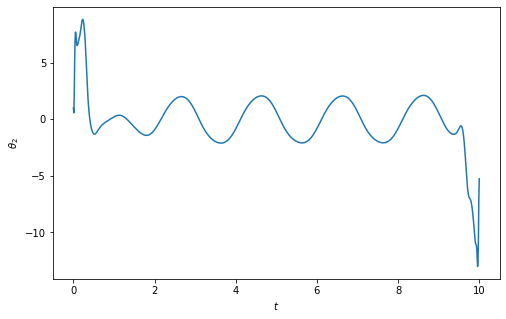

In [89]:
# Plot Solution
plt.figure(figsize=(8,5))
plt.plot(t, theta_2)
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_2$')
plt.show()

# Optimization

In [93]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import BarycentricInterpolator
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ─── 1) Synthetic reference data ────────────────────────────
t_ref = np.linspace(0, 10, 200)
A_ref, f_ref, damping, noise = 0.5, 1.5, 0.1, 0.02
theta2_ref = A_ref * np.exp(-damping * t_ref) * np.sin(2*np.pi*f_ref*t_ref)
theta2_ref += noise * np.random.randn(len(t_ref))


# Made-up data
n = 20 # keep below 30 for stability
t_array = np.linspace(0, 10, n)
y_array = 0.1 * cos(pi * t_array)
theta_1_array = sin(pi * t_array)


In [94]:
# ─── 2) Build your input interpolators ───────────────────────────────────────
n_input = 20
t_in = np.linspace(0, 2, n_input)
y_in = 0.1 * np.cos(np.pi * t_in)
theta1_in = np.sin(np.pi * t_in)
y_ip      = BarycentricInterpolator(t_in, y_in)
theta1_ip = BarycentricInterpolator(t_in, theta1_in)

def a_func(t):     return y_ip.derivative(t, 2)
def theta1_func(t):return theta1_ip(t)
def omega1_func(t):return theta1_ip.derivative(t, 1)
def alpha1_func(t):return theta1_ip.derivative(t, 2)

# ─── 3) Simulation wrapper now only takes 5 params ───────────────────────────
def simulate_theta2(free_params, t_eval):
    """
    free_params = [m1, m2, kB, bB, psiB]
    uses fixed l1, l2 from outer scope
    """
    m1, m2, kB, bB, psiB = free_params
    g = 9.81

    def swing_param(t, state):
        theta2, omega2 = state
        # inputs
        a   = a_func(t)
        th1 = theta1_func(t)
        om1 = omega1_func(t)
        alp1= alpha1_func(t)
        # EOM for swing‐leg angular acceleration
        alpha2 = (
            3*bB*om1/(l2**2*m2)
          - 3*bB*omega2/(l2**2*m2)
          - 3*g*np.sin(theta2)/(2*l2)
          - 3*kB*psiB/(l2**2*m2)
          + 3*kB*th1/(l2**2*m2)
          - 3*kB*theta2/(l2**2*m2)
          + 3*l1*np.sin(th1 - theta2)*om1**2/(2*l2)
          - 3*l1*np.cos(th1 - theta2)*alp1/(2*l2)
          - 3*np.sin(theta2)*a/(2*l2)
        )
        return [omega2, alpha2]

    # initial cond: start at ref angle, zero vel
    y0 = [theta2_ref[0], 0.0]
    sol = solve_ivp(swing_param,
                    (t_eval[0], t_eval[-1]),
                    y0,
                    t_eval=t_eval,
                    max_step=0.01)
    return sol.t, sol.y[0]

# ─── 4) Residuals function ───────────────────────────────────────────────────
def residuals(free_params):
    t_sim, th2_sim = simulate_theta2(free_params, t_ref)
    th2_on_ref = np.interp(t_ref, t_sim, th2_sim)
    return th2_on_ref - theta2_ref


In [95]:
# ─── 5) Parameters to optimize ────────────────────────────

H = 1.75
l1 = 0.25 * H    # femur
l2 = 0.25 * H    # tibia

# Initial Values
p0    = [5.0, 5.0,    # m1, m2
         1.0, 1.0,    # kB, bB
         np.pi/12]    # psiB

lower = [3, 3, 0.0, 0.0, 0.0]
upper = [10, 10, 10.0, 10.0, np.pi/6]

print("Starting optimization...")
result = least_squares(residuals, p0, bounds=(lower, upper),
                       xtol=1e-6, ftol=1e-6, verbose=2)

# ─── 6) Report fitted values ────────────────────────────────────────────────
names = ["m1","m2","kB","bB","psiB"]
print("\nFitted parameters:")
for name, val in zip(names, result.x):
    print(f"  {name} = {val:.4f}")


Starting optimization...


C:\Users\mehra\AppData\Local\Temp/ipykernel_13368/1297609230.py:32: RuntimeWarning: invalid value encountered in double_scalars
  3*bB*om1/(l2**2*m2)
C:\Users\mehra\AppData\Local\Temp/ipykernel_13368/1297609230.py:38: RuntimeWarning: invalid value encountered in sin
  + 3*l1*np.sin(th1 - theta2)*om1**2/(2*l2)
C:\Users\mehra\AppData\Local\Temp/ipykernel_13368/1297609230.py:39: RuntimeWarning: invalid value encountered in cos
  - 3*l1*np.cos(th1 - theta2)*alp1/(2*l2)


KeyboardInterrupt: 

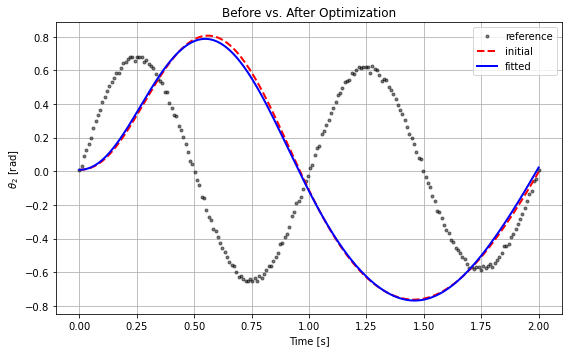

In [53]:
# ─── 7) (Optional) Plot before vs. after ────────────────────────────────────
_, th2_before = simulate_theta2(p0, t_ref)
_, th2_after  = simulate_theta2(result.x, t_ref)

plt.figure(figsize=(8,5))
plt.plot(t_ref, theta2_ref, 'k.', alpha=0.5, label='reference')
plt.plot(t_ref, th2_before,'r--', lw=2, label='initial')
plt.plot(t_ref, th2_after, 'b-',  lw=2, label='fitted')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta_2$ [rad]')
plt.legend()
plt.title('Before vs. After Optimization')
plt.grid(True)
plt.tight_layout()
plt.show()


In [112]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import BarycentricInterpolator
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ─── 1) Synthetic reference data ────────────────────────────
t_ref = np.linspace(0, 10, 200)
A_ref, f_ref, damping, noise = 0.5, 1.5, 0.5, 0.02
theta2_ref = A_ref * np.exp(-damping * t_ref) * np.sin(2*np.pi*f_ref*t_ref)
theta2_ref += noise * np.random.randn(len(t_ref))

# Realistic gait parameters
#t_ref = np.linspace(0, 10, 200)  # 2 seconds, typical walking stride duration
#A_ref = 0.5 #np.deg2rad(40)           # amplitude ~40 degrees in radians (~0.7 rad)
#f_ref = 0.75                    # frequency ~1.2 Hz (typical walking step frequency)
#damping = 0.5                  # low damping to mimic steady gait
#noise = 0.05                    # small noise level for realism

# Synthetic gait angle data (theta2_ref)
#theta2_ref = A_ref * np.exp(-damping * t_ref) * np.sin(2 * np.pi * f_ref * t_ref)
#theta2_ref += noise * np.random.randn(len(t_ref))

# ─── 2) Build your input interpolators ───────────────────────────────────────
n_input = 20
t_in = np.linspace(0, 10, n_input)
y_in = 0.1 * np.cos(np.pi * t_in)
theta1_in = np.sin(np.pi * t_in)
y_ip      = BarycentricInterpolator(t_in, y_in)
theta1_ip = BarycentricInterpolator(t_in, theta1_in)

def a_func(t):     return y_ip.derivative(t, 2)
def theta1_func(t):return theta1_ip(t)
def omega1_func(t):return theta1_ip.derivative(t, 1)
def alpha1_func(t):return theta1_ip.derivative(t, 2)

# ─── 3) Simulation wrapper now only takes 5 params ───────────────────────────
def simulate_theta2(free_params, t_eval):
    """
    free_params = [m1, m2, kB, bB, psiB]
    uses fixed l1, l2 from outer scope
    """
    m1, m2, kB, bB, psiB = free_params
    g = 9.81

    def swing_param(t, state):
        theta2, omega2 = state
        # inputs
        a   = a_func(t)
        th1 = theta1_func(t)
        om1 = omega1_func(t)
        alp1= alpha1_func(t)
        # EOM for swing‐leg angular acceleration
        alpha2 = (
            3*bB*om1/(l2**2*m2)
          - 3*bB*omega2/(l2**2*m2)
          - 3*g*np.sin(theta2)/(2*l2)
          - 3*kB*psiB/(l2**2*m2)
          + 3*kB*th1/(l2**2*m2)
          - 3*kB*theta2/(l2**2*m2)
          + 3*l1*np.sin(th1 - theta2)*om1**2/(2*l2)
          - 3*l1*np.cos(th1 - theta2)*alp1/(2*l2)
          - 3*np.sin(theta2)*a/(2*l2)
        )
        return [omega2, alpha2]

    # initial cond: start at ref angle, zero vel
    y0 = [theta2_ref[0], 0.0]
    sol = solve_ivp(swing_param,
                    (t_eval[0], t_eval[-1]),
                    y0,
                    t_eval=t_eval,
                    max_step=0.01)
    return sol.t, sol.y[0]

# ─── 4) Residuals function ───────────────────────────────────────────────────
def residuals(free_params):
    t_sim, th2_sim = simulate_theta2(free_params, t_ref)
    th2_on_ref = np.interp(t_ref, t_sim, th2_sim)
    return th2_on_ref - theta2_ref


In [113]:
H = 1.75
l1 = 0.25 * H    # femur
l2 = 0.25 * H    # tibia

# Initial Values
p0    = [5.0, 5.0,    # m1, m2
         1.0, 1.0,    # kB, bB
         np.pi/12]    # psiB

lower = [3, 3, 0.0, 0.0, 0.0]
upper = [20, 20, 10.0, 10.0, np.pi/6]

print("Starting optimization...")
result = least_squares(residuals, p0, bounds=(lower, upper),
                       xtol=1e-6, ftol=1e-6, verbose=2)

# ─── 6) Report fitted values ────────────────────────────────────────────────
names = ["m1","m2","kB","bB","psiB"]
print("\nFitted parameters:")
for name, val in zip(names, result.x):
    print(f"  {name} = {val:.4f}")


Starting optimization...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2041e+03                                    1.08e+04    
       1              2         8.9050e+02      2.31e+03       2.44e+00       3.10e+02    
       2              3         8.0151e+02      8.90e+01       2.20e+00       1.85e+02    
       3              4         4.5258e+02      3.49e+02       2.79e+00       1.09e+02    
       4              5         4.2235e+02      3.02e+01       2.02e+00       1.26e+01    
       5              6         4.1427e+02      8.08e+00       8.64e-01       6.81e+00    
       6              7         4.1127e+02      3.00e+00       2.29e+00       4.92e+00    
       7              8         4.0960e+02      1.67e+00       4.26e-01       3.18e+00    
       8              9         4.0872e+02      8.81e-01       2.91e-01       2.20e+00    
       9             10         4.0811e+02      6.03e-01       2.

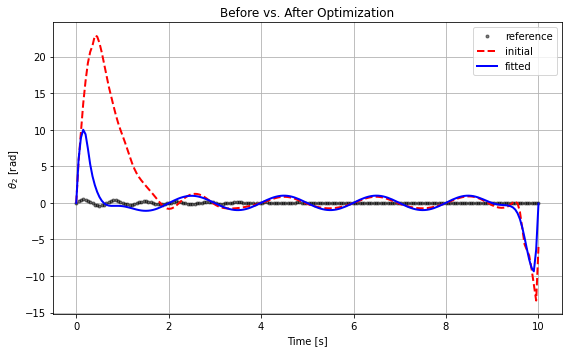

In [114]:
# ─── 7) (Optional) Plot before vs. after ────────────────────────────────────
_, th2_before = simulate_theta2(p0, t_ref)
_, th2_after  = simulate_theta2(result.x, t_ref)

plt.figure(figsize=(8,5))
plt.plot(t_ref, theta2_ref, 'k.', alpha=0.5, label='reference')
plt.plot(t_ref, th2_before,'r--', lw=2, label='initial')
plt.plot(t_ref, th2_after, 'b-',  lw=2, label='fitted')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta_2$ [rad]')
plt.legend()
plt.title('Before vs. After Optimization')
plt.grid(True)
plt.tight_layout()
plt.show()